In [1]:
## This is for the further analsis of national scale heat exposure
## In order to run this notebook
## Please first
## Get the heat exposure result from National_HE_Twitter.ipny
## And run data_collection.ipny to collection socioeconomic data

In [2]:
## upgrade the pandas package before continue
## Please refresh the kernel after upgrade
!pip install pandas --upgrade

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.7 MB 15.3 MB/s            00:01��█████████████▌                 | 5.3 MB 15.3 MB/s eta 0:00:01▉         | 8.3 MB 15.3 MB/s eta 0:00:01
     |████████████████████████████████| 247 kB 58.4 MB/s            
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pointpats 2.2.0 requires opencv-contrib-python>=4.2.0, which is not installed.
lidar 0.6.2 requires pygdal==1.10.0.0, which is not installed.
pysal 2.5.0 requires python-dateutil<=2.8.0, but you have python-dateutil 2.8.2 which is incompatible.
pysal 2.5.0 requires urllib3>=1.26, but you have urllib3 1.25.11 which is incompatible.
lidar 0.6.2 requires PySimpleGUI==2.30.0, but you have pysimplegui 4.56.0 which is incompatible.
geosnap 0.8.2 requires quilt3>=3.6, but you have quilt3 3.5.0 which is

In [3]:
import pytz
from datetime import datetime, timedelta
import os
import geopandas as gpd
import json
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
import re
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import numpy as np

In [4]:
## read the csv file
df = pd.read_csv('./output/national_heat_exposure.csv')
df

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,number_of_twitter,heat_exposure,normalized_heat_exposure,number_of_twitter_for_quantile
0,5,121,69178,0500000US05121,5121,Randolph,Randolph County,AR,Arkansas,6,1688445990,10370823,"POLYGON ((-91.404915 36.49712, -91.12653766071...",0,NaN,NaN,NaN
1,8,69,198150,0500000US08069,8069,Larimer,Larimer County,CO,Colorado,6,6723014102,98984559,"POLYGON ((-106.190554078709 40.9977466125744, ...",18,-0.292958,0.429290,18.0
2,26,105,1622995,0500000US26105,26105,Mason,Mason County,MI,Michigan,6,1281963206,1935616622,"POLYGON ((-86.514702 44.058119, -86.4580652757...",0,NaN,NaN,NaN
3,28,153,695797,0500000US28153,28153,Wayne,Wayne County,MS,Mississippi,6,2099745602,7255476,"POLYGON ((-88.943355 31.824565, -88.910459 31....",0,NaN,NaN,NaN
4,38,75,1034229,0500000US38075,38075,Renville,Renville County,ND,North Dakota,6,2272050275,40658499,"POLYGON ((-102.021643 48.807108, -102.02121763...",0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,16,77,394951,0500000US16077,16077,Power,Power County,ID,Idaho,6,3635892401,99205466,"POLYGON ((-113.243478 43.110946, -113.007712 4...",0,NaN,NaN,NaN
3217,46,85,1265789,0500000US46085,46085,Lyman,Lyman County,SD,South Dakota,6,4253498542,167300393,"POLYGON ((-100.367247 44.194621, -99.938216999...",0,NaN,NaN,NaN
3218,55,115,1581117,0500000US55115,55115,Shawano,Shawano County,WI,Wisconsin,6,2313441749,41883059,"POLYGON ((-89.223814 45.029246, -88.98168 45.0...",1,-0.145698,0.471636,1.0
3219,16,69,399394,0500000US16069,16069,Nez Perce,Nez Perce County,ID,Idaho,6,2197139835,21252880,"POLYGON ((-117.035545 46.410012, -117.03664574...",0,NaN,NaN,NaN


In [5]:
soc= pd.read_csv("soceco.csv")

In [6]:
soc

,Unnamed: 0,state,county,pop,black,white,asian,hispanic,income
0,0,1,115,87306,0.094518,0.873067,0.008442,0.023927,779
1,1,1,43,82313,0.012124,0.952365,0.004058,0.043043,671
2,2,1,69,104352,0.269070,0.693681,0.008366,0.032937,736
3,3,1,125,206213,0.316469,0.644368,0.016013,0.036065,891
4,4,1,31,51288,0.172146,0.758910,0.012985,0.069197,739
...,...,...,...,...,...,...,...,...,...
3163,72,72,47,34165,0.064920,0.796371,0.000000,0.989639,230
3164,73,72,95,11023,0.729293,0.254649,0.000000,0.988479,197
3165,74,72,113,143926,0.054431,0.773856,0.000660,0.993483,272
3166,75,72,131,37964,0.028738,0.702718,0.002766,0.977953,222


In [7]:
## Find the hitogram of normailized heat index
nhe = list(df["normalized_heat_exposure"])
## remove non-existing value
nhe_list = []
for e in nhe:
    if (e>=0 and e<=1):
        nhe_list.append(e)
len(nhe_list)

1230

Text(0.5, 1.0, 'Histogram of Normailized Heat Exposure for counties')

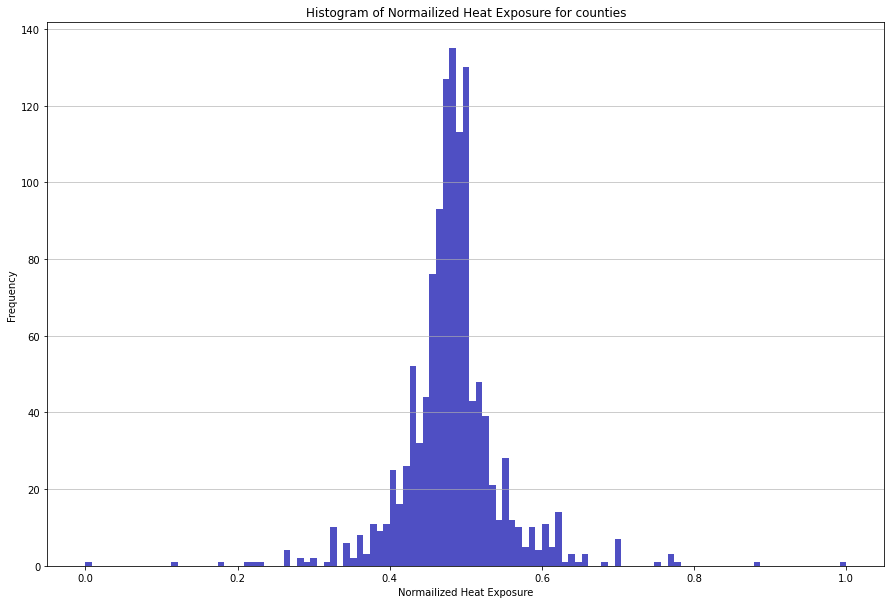

In [8]:
%matplotlib inline
plt.figure(figsize=(15,10))
plt.hist(nhe_list, bins='auto', color='#0504aa',alpha=0.7)
plt.grid(axis='y', alpha=0.8)
plt.xlabel('Normailized Heat Exposure')
plt.ylabel('Frequency')
plt.title('Histogram of Normailized Heat Exposure for counties')

In [9]:
## merge two dataframe
GEOID = []
for index, row in soc.iterrows():
    state = str(int(row['state']))
    county = str(int(row['county']))
    while (len(county)!=3):
        #print(county)
        county = '0'+county
    geo = state+county
    GEOID.append(int(geo))
soc["GEOID"] = GEOID
df_soc = pd.merge(df, soc, on='GEOID')

In [10]:
## normalized heat exposure against ethic income ...

In [11]:
## setset for dataframe that has not
county_with_twitter = df_soc[df_soc["number_of_twitter"]!=0]

In [12]:
county_with_twitter

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,...,number_of_twitter_for_quantile,Unnamed: 0,state,county,pop,black,white,asian,hispanic,income
1,8,69,198150,0500000US08069,8069,Larimer,Larimer County,CO,Colorado,6,...,18.0,23,8,69,338161,0.009685,0.914561,0.022194,0.113328,1292
9,40,101,1101838,0500000US40101,40101,Muskogee,Muskogee County,OK,Oklahoma,6,...,1.0,75,40,101,69084,0.107883,0.582117,0.007238,0.060274,675
12,48,259,1383915,0500000US48259,48259,Kendall,Kendall County,TX,Texas,6,...,2.0,187,48,259,41982,0.007694,0.902434,0.008789,0.235672,1314
13,31,79,835861,0500000US31079,31079,Hall,Hall County,NE,Nebraska,6,...,1.0,52,31,79,61343,0.024991,0.876775,0.011265,0.272305,796
17,18,109,450375,0500000US18109,18109,Morgan,Morgan County,IN,Indiana,6,...,1.0,75,18,109,69727,0.003040,0.974945,0.007243,0.015102,900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3157,39,91,1074058,0500000US39091,39091,Logan,Logan County,OH,Ohio,6,...,1.0,68,39,91,45307,0.016797,0.947160,0.008586,0.015031,796
3159,28,89,695768,0500000US28089,28089,Madison,Madison County,MS,Mississippi,6,...,51.0,27,28,89,103498,0.380548,0.570939,0.025566,0.029508,1052
3160,49,43,1448035,0500000US49043,49043,Summit,Summit County,UT,Utah,6,...,1.0,4,49,43,40511,0.007504,0.939597,0.016465,0.115080,1585
3161,37,189,1008594,0500000US37189,37189,Watauga,Watauga County,NC,North Carolina,6,...,5.0,16,37,189,54117,0.016631,0.939150,0.009535,0.034777,805


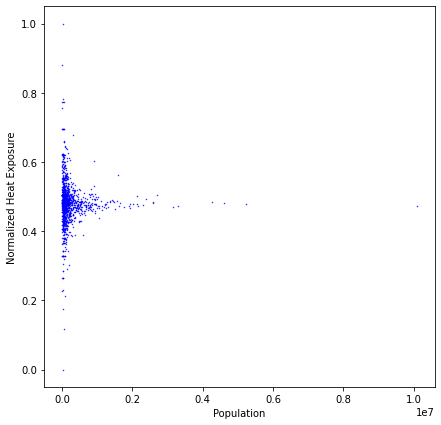

In [13]:
import matplotlib.pyplot as plt
## pop
x = list(county_with_twitter['pop'])
y = list(county_with_twitter['normalized_heat_exposure'])
plt.figure(figsize=(7,7))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('Population')
plt.ylabel('Normalized Heat Exposure')
plt.show()

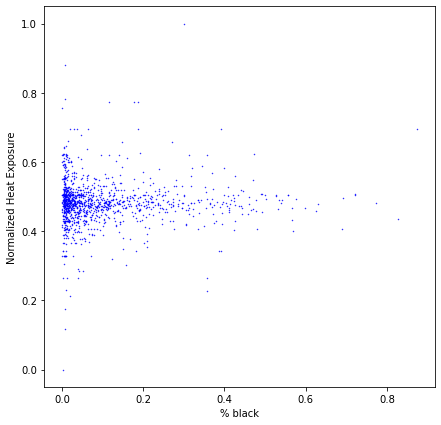

In [14]:
x = list(county_with_twitter['black'])
y = list(county_with_twitter['normalized_heat_exposure'])
plt.figure(figsize=(7,7))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('% black')
plt.ylabel('Normalized Heat Exposure')
plt.show()

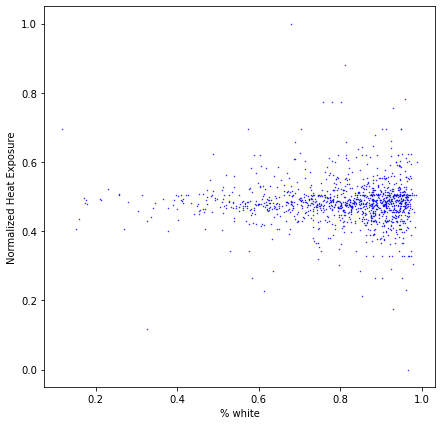

In [15]:
x = list(county_with_twitter['white'])
y = list(county_with_twitter['normalized_heat_exposure'])
plt.figure(figsize=(7,7))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('% white')
plt.ylabel('Normalized Heat Exposure')
plt.show()

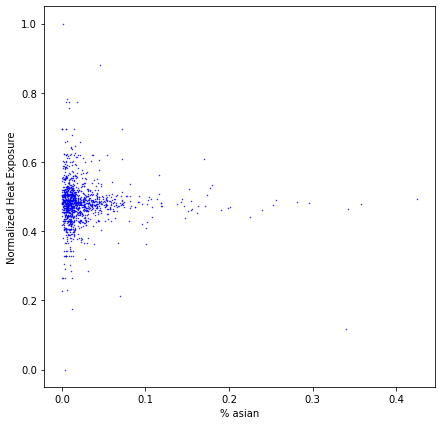

In [16]:
x = list(county_with_twitter['asian'])
y = list(county_with_twitter['normalized_heat_exposure'])
plt.figure(figsize=(7,7))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('% asian')
plt.ylabel('Normalized Heat Exposure')
plt.show()

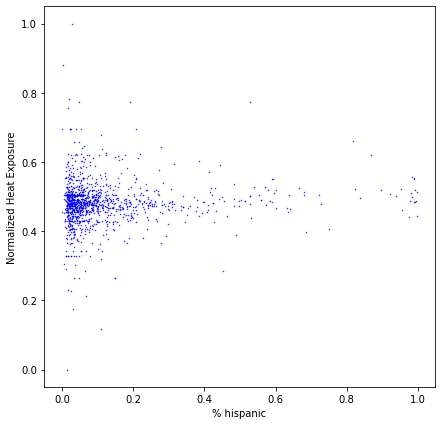

In [17]:
x = list(county_with_twitter['hispanic'])
y = list(county_with_twitter['normalized_heat_exposure'])
plt.figure(figsize=(7,7))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('% hispanic')
plt.ylabel('Normalized Heat Exposure')
plt.show()

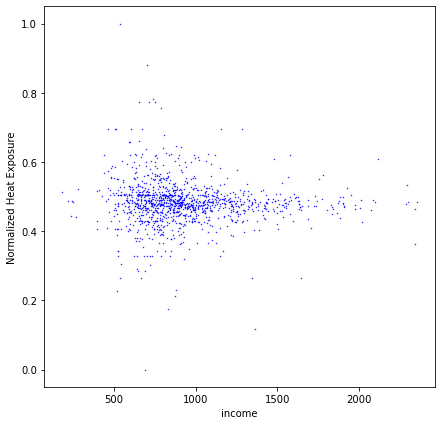

In [18]:
x = list(county_with_twitter['income'])
y = list(county_with_twitter['normalized_heat_exposure'])
plt.figure(figsize=(7,7))
plt.scatter(x, y, c ="blue", s=0.2)
plt.xlabel('income')
plt.ylabel('Normalized Heat Exposure')
plt.show()

In [19]:
## Fit a simple regression model based on socioecomic data
from sklearn.linear_model import LinearRegression
## Y is the normalized heat expsure
Y = []
X = []
for index, row in county_with_twitter.iterrows():
    nhe = row['normalized_heat_exposure']
    pop = row['pop']
    black = row['black']
    white = row['white']
    asian = row['asian']
    hispa = row['hispanic']
    incom = row['income']
    Y.append(nhe)
    X.append([pop, black, white, asian, hispa, incom])

In [20]:
df = pd.DataFrame({'x':X, 'y':Y})

In [21]:
## ANOVA test
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [22]:
model = ols('normalized_heat_exposure ~ pop+black+white+asian+hispanic+income', data=county_with_twitter).fit()

In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     normalized_heat_exposure   R-squared:                       0.011
Model:                                  OLS   Adj. R-squared:                  0.007
Method:                       Least Squares   F-statistic:                     2.323
Date:                      Fri, 18 Mar 2022   Prob (F-statistic):             0.0310
Time:                              23:44:04   Log-Likelihood:                 1571.5
No. Observations:                      1205   AIC:                            -3129.
Df Residuals:                          1198   BIC:                            -3093.
Df Model:                                 6                                         
Covariance Type:                  nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4539      0.029     15.718      0.000       0.397       0.511
pop        -6.707e-10   4.37e-09     -0.153      0.878   -9.24e-09     7.9e-09
black          0.0505      0.032      1.567      0.117      -0.013       0.114
white          0.0341      0.030      1.132      0.258      -0.025       0.093
asian          0.0080      0.082      0.097      0.922      -0.152       0.168
hispanic       0.0374      0.013      2.880      0.004       0.012       0.063
income     -9.856e-06   7.62e-06     -1.294      0.196   -2.48e-05    5.09e-06
==============================================================================
Omnibus:                      234.799   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4679.127
Skew:                           0.301   Prob(JB):                         0.00
Kurtosis:                      12.635   Cond. No.                     2.57e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.57e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
pop,0.000102,1.0,0.023562,0.878031
black,0.010654,1.0,2.456042,0.117338
white,0.005563,1.0,1.282538,0.257654
asian,0.000041,1.0,0.009505,0.922349
hispanic,0.035974,1.0,8.293334,0.004050
income,0.007265,1.0,1.674848,0.195860
Residual,5.196555,1198.0,NaN,NaN


In [25]:
county_with_twitter

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,...,number_of_twitter_for_quantile,Unnamed: 0,state,county,pop,black,white,asian,hispanic,income
1,8,69,198150,0500000US08069,8069,Larimer,Larimer County,CO,Colorado,6,...,18.0,23,8,69,338161,0.009685,0.914561,0.022194,0.113328,1292
9,40,101,1101838,0500000US40101,40101,Muskogee,Muskogee County,OK,Oklahoma,6,...,1.0,75,40,101,69084,0.107883,0.582117,0.007238,0.060274,675
12,48,259,1383915,0500000US48259,48259,Kendall,Kendall County,TX,Texas,6,...,2.0,187,48,259,41982,0.007694,0.902434,0.008789,0.235672,1314
13,31,79,835861,0500000US31079,31079,Hall,Hall County,NE,Nebraska,6,...,1.0,52,31,79,61343,0.024991,0.876775,0.011265,0.272305,796
17,18,109,450375,0500000US18109,18109,Morgan,Morgan County,IN,Indiana,6,...,1.0,75,18,109,69727,0.003040,0.974945,0.007243,0.015102,900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3157,39,91,1074058,0500000US39091,39091,Logan,Logan County,OH,Ohio,6,...,1.0,68,39,91,45307,0.016797,0.947160,0.008586,0.015031,796
3159,28,89,695768,0500000US28089,28089,Madison,Madison County,MS,Mississippi,6,...,51.0,27,28,89,103498,0.380548,0.570939,0.025566,0.029508,1052
3160,49,43,1448035,0500000US49043,49043,Summit,Summit County,UT,Utah,6,...,1.0,4,49,43,40511,0.007504,0.939597,0.016465,0.115080,1585
3161,37,189,1008594,0500000US37189,37189,Watauga,Watauga County,NC,North Carolina,6,...,5.0,16,37,189,54117,0.016631,0.939150,0.009535,0.034777,805


In [28]:
pop = list(county_with_twitter["pop"])
bla = list(county_with_twitter["black"])
whi = list(county_with_twitter["white"])
asi = list(county_with_twitter["asian"])
his = list(county_with_twitter["hispanic"])
inc = list(county_with_twitter["income"])

y = list(county_with_twitter["normalized_heat_exposure"])

In [31]:
import scipy
print(scipy.stats.pearsonr(pop, y))
print(scipy.stats.spearmanr(pop, y))

(-0.01368357463728154, 0.6351229564640106)
SpearmanrResult(correlation=-0.06966332198726725, pvalue=0.015577809691934095)


In [32]:
print(scipy.stats.pearsonr(bla, y))
print(scipy.stats.spearmanr(bla, y))

(0.029095973020302424, 0.3128896912825577)
SpearmanrResult(correlation=-0.022484236883937577, pvalue=0.4355166542738437)


In [33]:
print(scipy.stats.pearsonr(whi, y))
print(scipy.stats.spearmanr(whi, y))

(-0.01073960749921279, 0.7095734628486109)
SpearmanrResult(correlation=0.0006050789107392659, pvalue=0.9832597163375236)


In [34]:
print(scipy.stats.pearsonr(asi, y))
print(scipy.stats.spearmanr(asi, y))

(-0.04583195917024233, 0.11180003069152387)
SpearmanrResult(correlation=-0.05696105400822437, pvalue=0.04805877503670663)


In [35]:
print(scipy.stats.pearsonr(his, y))
print(scipy.stats.spearmanr(his, y))

(0.07001341949772236, 0.015063674634277362)
SpearmanrResult(correlation=0.043061900687093785, pvalue=0.13518761439821886)


In [36]:
print(scipy.stats.pearsonr(inc, y))
print(scipy.stats.spearmanr(inc, y))

(-0.06059503150063191, 0.03544901019084794)
SpearmanrResult(correlation=-0.08839328377138451, pvalue=0.0021317559709551873)
